## IN3050/IN4050 Mandatory Assignment 2: Supervised Learning

# GUSTAV LILLESÆTER (GUSTAVLI)

-------

README:
Did not manage to complete all the exercises, but I have attempted all of them. I would appreaciate some feedback for the classifiers if I have not implemented them correctly. Also some pointers for the parts where I am not completely finished yet. I hope I get a chance to deliver a second attempt.

### Rules

Before you begin the exercise, review the rules at this website: https://www.uio.no/english/studies/examinations/compulsory-activities/mn-ifi-mandatory.html (This is an individual assignment. You are not allowed to deliver together or copy/share source-code/answers with others.)
### Delivering

**Deadline**: Wednesday, March 25, 2020, 23:59

Your submission should be delivered in Devilry. You may redeliver in Devilry before the deadline, but include all files in the last delivery, as only the last delivery will be read. You are recommended to upload preliminary versions hours (or days) before the final deadline.

### What to deliver?

You are recommended to solve the exercise in a Jupyter notebook, but you might solve it in a Python program if you prefer.

If you choose Jupyter, you should deliver the notebook. You should answer all questions and explain what you are doing in Markdown. Still, the code should be properly commented. The notebook should contain results of your runs. In addition, you should make a pdf of your solution. (If you have problems making a pdf at your own machine, you can make it at the IFI linux cluster.)

If you prefer not to use notebooks, you should deliver the code, your run results, and a pdf-report where you answer all the questions and explain your work.

Your report/notebook should contain your name and username.

Deliver one single zipped folder (.zip, .tgz or .tar.gz) which contains your complete solution.

Important: if you weren’t able to finish the assignment, use the PDF report/Markdown to elaborate on what you’ve tried and what problems you encountered. Students who have made an effort and attempted all parts of the assignment will get a second chance even if they fail initially. This exercise will be graded PASS/FAIL.


### Goals of the exercise
This exercise has three parts. The goal of the first part is to get some more experience with supervised classification. We will use simple synthetic datasets and focus on the learning algorithms. 

The goal of the second part is to consider the implementaion of the  Multi-layer feed forward neural network, often called Multi-layer perceptron (MLP).

The third part, which is the smallest one, is dedicated to evaluation.

### Tools
The aim of the exercises is to give you a look inside the learning algorithms. You may freely use code from the weekly exercises and the published solutions. You should not use ML libraries like scikit-learn or tensorflow.

You may use tools like NumPy and Pandas, which are not specific ML-tools.

### Beware
This is a new assignment. There might occur typos or ambiguities. If anything is unclear, do not hesitate to ask. Also, if you think some assumptions are missing, make your
own and explain them!

### Intialization

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets
import random

from IPython.display import display

# Part 1: Comparing classifiers
## Datasets
We start by making a synthetic dataset of 1600 datapoints and three classes, with 800 individuals in one class and 400 in each of the two other classes. (See https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html#sklearn.datasets.make_blobs regarding how the data are generated.)

When we are doing experiments in supervised learning, and the data are not already split into training and test sets, we should start by splitting the data. Sometimes there are natural ways to split the data, say training on data from one year and testing on data from a later year, but if that is not the case, we should shuffle the data randomly before splitting. (OK, that is not necessary with this particular synthetic data set, since it is already shuffled by default by scikit, but that will not be the case with real-world data.) We should split the data so that we keep the alignment between X and t, which may be achieved by shuffling the indices. We split into 50% for training, 25% for validation, and 25% for final testing. The set for final testing *must not be used* till the and of the assignment in part 3.

We fix the seed both for data set generation and for shuffling, so that we work on the same datasets when we rerun the experiments.

In [21]:
from sklearn.datasets import make_blobs
X, t = make_blobs(n_samples=[400,800,400], centers=[[0,0],[1,2],[2,3]],n_features=2, random_state=2019)

In [22]:
indices = np.arange(X.shape[0])
random.seed(2020)
random.shuffle(indices)
indices[:10]

array([1301,  293,  968,  624,  658,  574,  433,  368,  512,  353])

In [23]:
X_train = X[indices[:800],:]
X_val = X[indices[800:1200],:]
X_test = X[indices[1200:],:]
t_train = t[indices[:800]]
t_val = t[indices[800:1200]]
t_test = t[indices[1200:]]


Next, we will  make a second dataset by merging the two smaller classes in (X,t) and call the new set (X, t2). This will be a binary set.

In [24]:
t2_train = t_train == 1
t2_train = t2_train.astype('int')
t2_val = (t_val == 1).astype('int')
t2_test = (t_test == 1).astype('int')


Plot the two training sets.

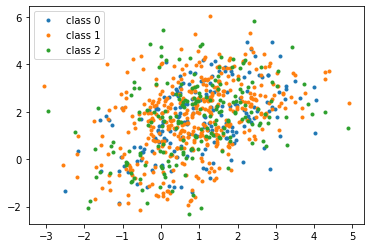

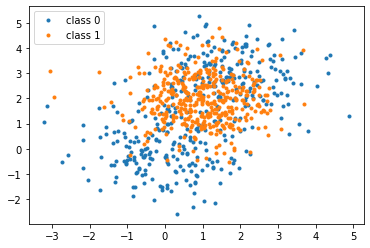

In [25]:
# Your solution

def show(xvals,yvals,marker='.'):
    labels = set(yvals)
    cl = { lab : []  for lab in labels}
    for (a,b) in zip(xvals,yvals):
        cl[b].append(a)
    for lab in labels:
        plt.plot([a[0] for a in cl[lab]], [a[1] for a in cl[lab]], marker, label="class {}".format(lab))
    plt.legend()
    plt.show()
    plt.close()
    
show(X,t_train)
show(X_train,t2_train)
                 

## Binary classifiers

In [26]:
class PyClassifier():
    def accuracy(self,X_test,y_test, **kwargs):
        predicted = [self.predict(a,**kwargs) for a in X_test]
        equal = len([(p,g) for (p,g) in zip(predicted,y_test) if p==g])
        return equal/len(y_test)
        

### Linear regression
We see that that set (X, t2) is far from linearly separable, and we will explore how various classifiers are able to handle this. We start with linear regression. You may use the implementation from exercise set week07 or make your own. You should make one improvement. The implementation week07 runs for a set number of epochs. You provide the number of epochs with a parameter to the fit-method. However, you do not know what a reasonable number of epochs is. Add one more argument to the fit-method *diff* (with defualt value e.g. 0.001). The training should stop when the update is less than *diff*. The *diff* will save training time, but it may also be wise to not set it too small -- and not run training for too long -- to avoid overfitting.

Train the classifier on (X_train, t2_train) and test for accuracy on (X_val, t2_val) for various values of *diff*. Choose what you think is optimal *diff*. Report accuracy and save it for later.

In [27]:
import math
def add_bias(X):
    sh = X.shape
    m = sh[0]
    bias = np.ones((m,1))
    return np.concatenate([bias,X],axis=1)

class LinReg(PyClassifier):
    def accuracy(self,X_test,y_test,**kwargs):
        pred = self.predict(X_test, **kwargs)
        if len(pred.shape) > 1:
            pred = pred[:,0]
        return sum(pred==y_test) / len(pred)
        
    def fit(self, X_train, Y_train, gamma=0.1, epochs=10, diff=0.001):
        (k,m) = X_train.shape
        X_train = add_bias(X_train)
        
        self.theta = theta = np.zeros(m+1)
        
        for e in range(epochs):
            ch = gamma / k * X_train.T @ (X_train @ theta - t_train)
            for i in ch:
                if abs(i)<diff:
                    return
            theta -= ch
    def predict(self, x, threshold=0.5):
        z = add_bias(x)
        score = z @ self.theta
        return score>threshold
    
    def plot(self,xvals,yvals, marker = '.'):
        labels = set(yvals)
        cl = { lab : []  for lab in labels}
        for (a,b) in zip(xvals,yvals):
            cl[b].append(a)
        for lab in labels:
            plt.plot([a[0] for a in cl[lab]], [a[1] for a in cl[lab]], marker, label="class {}".format(lab))
        plt.legend()
        
        plt.plot(X,self.theta[0]+self.theta[1]*X, color = "r")
        
        plt.show()
        plt.close()
        

def testLinReg():
    diff = 0.00001
    while diff < 1:
        clf = LinReg()
        clf.fit(X_train,t2_train,diff=diff)
        print("diff = {} | Accuracy = {}".format(diff,clf.accuracy(X_val,t2_val)))
        diff*=10
    #clf = LinReg()
    #clf.fit(X_train,t2_train)
    #clf.plot(X_train,t2_train)
    #print(clf.accuracy(X_val,t2_val))

testLinReg()


diff = 1e-05 | Accuracy = 0.67
diff = 0.0001 | Accuracy = 0.67
diff = 0.001 | Accuracy = 0.6725
diff = 0.01 | Accuracy = 0.67
diff = 0.1 | Accuracy = 0.5275


### Logistic regression
Do the same for logistic regression, i.e., add the *diff*, tune it, report accuracy, and store it for later.

In [28]:
def logistic(x):
    return 1/(1+np.exp(-x))
class LogReg(PyClassifier):
    
    def accuracy(self,X_test,y_test,**kwargs):
        pred = self.predict(X_test, **kwargs)
        if len(pred.shape) > 1:
            pred = pred[:,0]
        return sum(pred==y_test) / len(pred)
    
    def fit(self,X_train,t_train,gamma=0.1,epochs=10,diff=0.001):
        (k,m) = X_train.shape
        X_train = add_bias(X_train)
        self.theta = theta = np.zeros(m+1)
        
        for e in range(epochs):
            ch = gamma / k * X_train.T @ (self.forward(X_train) - t_train)
            theta -= ch
    def forward(self,X):
        return logistic(X @ self.theta)
    def score(self,x):
        z=add_bias(x)
        score = self.forward(z)
        return score
    def predict(self,x,threshold=0.5):
        z=add_bias(x)
        score=self.forward(z)
        return (score>threshold).astype(int)

def testLogReg():
    clf = LogReg()
    clf.fit(X_train,t2_train)
    acc = clf.predict(X_val,t2_val)
    print("accuracy: ",clf.accuracy(X_val,t2_val))

testLogReg()


accuracy:  0.595


### *k*-nearest neighbors (*k*NN)
We will now compare to the *k*-nearest neighbors classifier. You may use the implementation from the week05 exercise set. Beware, though, that we represented the data differently from what we do here, using Python lists instead of numpy arrays. You therefore have to either modify the representation of the data or the code a little.

Train on (X_train, t2_train) and test on (X2_val, x2_val) for various values of *k*. Choose the best *k*, report accuracy and store for later.

In [29]:
def majority(a):
    from collections import Counter
    counts = Counter(a)
    return counts.most_common()[0][0]
def distance(a,b):
    s=0
    for (x,y) in zip(a,b):
        s+=(x-y)**2
    return s**0.5
    
class kNNClassifier(PyClassifier):
    def __init__(self, k=3):
        self.k=k
    
    def fit(self, X_train, y_train):
        self.X_train=X_train
        self.y_train=y_train
    
    def predict(self, a):
        X=self.X_train
        y=self.y_train
        distances = [(distance(a,b),b,c) for (b,c) in zip(X,y)]
        distances.sort()
        predictors = [c for (_,_,c) in distances[0:self.k]]
        return majority(predictors)

def testKnn(start, end):
    for i in range(start,end,2):
        clf = kNNClassifier(k=i)
        clf.fit(X_train,t2_train)
        accuracy = clf.accuracy(X_val,t2_val)
        print("k = %02d | accuracy = %.3f" % (i,accuracy))

testKnn(1,30)


k = 01 | accuracy = 0.670
k = 03 | accuracy = 0.680
k = 05 | accuracy = 0.713
k = 07 | accuracy = 0.735
k = 09 | accuracy = 0.733
k = 11 | accuracy = 0.738
k = 13 | accuracy = 0.748
k = 15 | accuracy = 0.752
k = 17 | accuracy = 0.750
k = 19 | accuracy = 0.752
k = 21 | accuracy = 0.757
k = 23 | accuracy = 0.750
k = 25 | accuracy = 0.752
k = 27 | accuracy = 0.748
k = 29 | accuracy = 0.755


### Simple perceptron
Finally, run the simple perceptron (week05) on the same set, and report and store accuracy.

In [30]:
class PerceptronClassifier(PyClassifier):
    def fit(self, X_train, y_train, eta=0.01, epochs=10):
        random.seed(2020)
        X_train = [[1]+list(x) for x in X_train]
        self.dim = dim = len(X_train[0])
        self.weights = weights = [1 for _ in range(dim)]
        
        for e in range(epochs):
            for x, t in zip(X_train,y_train):
                y=int(self.forward(x)>0)
                for i in range(dim):
                    weights[i]+=eta*(t-y)*x[i]
    
    def forward(self, x):
        score = sum([self.weights[i]*x[i] for i in range(self.dim)])
        return score
    def predict(self,x):
        x = [1]+list(x)
        score = self.forward(x)
        return int(score>0)

def testPerceptron():
    for i in range(1,50,3):
        clf = PerceptronClassifier()
        clf.fit(X_train,t2_train,epochs=i)
        acc = clf.accuracy(X_val,t2_val)
        print("epochs= %02d | accuracy = %.3f" % (i,acc))

testPerceptron()

epochs= 01 | accuracy = 0.598
epochs= 04 | accuracy = 0.575
epochs= 07 | accuracy = 0.585
epochs= 10 | accuracy = 0.603
epochs= 13 | accuracy = 0.642
epochs= 16 | accuracy = 0.593
epochs= 19 | accuracy = 0.620
epochs= 22 | accuracy = 0.640
epochs= 25 | accuracy = 0.657
epochs= 28 | accuracy = 0.595
epochs= 31 | accuracy = 0.637
epochs= 34 | accuracy = 0.632
epochs= 37 | accuracy = 0.547
epochs= 40 | accuracy = 0.588
epochs= 43 | accuracy = 0.580
epochs= 46 | accuracy = 0.598
epochs= 49 | accuracy = 0.583


### Summary
Report the accuracies for the four classifiers in a table.

Write a couple of sentences where you comment on what you see. Are the results as you expected?

| clf | res    |
|-----|--------|
| knn | 0.757  |
| lin | 0.6725 |
| log | 0.595  |
| per | 0.657  |

Knn performs well, which makes sense if we look at the plotted data. Class 1 is mostly in the middle and class 0 is divided below and above. Regression classifiers are not ideal in this scenario as there is no logical place for the line to "cut" as class 0 is on both sides of class 1.

## Multi-class classifiers
We now turn to the task of classifying when there are more than two classes, and the task is to ascribe one class to each input. We will now use the set (X, t).

### *k*NN
One of the classifiers can handle multiple classes without modifications: the *k*-nearest neighbors classifier. Train it on (X_train, t_train), test it on (X_val, t_val) for various values of *k*. Choose the one you find best and report the accuracy.

In [31]:
for i in range(1,30,2):
    clf = kNNClassifier(k=i)
    clf.fit(X_train,t_train)
    print("k={} | accuracy={}".format(i,clf.accuracy(X_val,t_val)))


k=1 | accuracy=0.6625
k=3 | accuracy=0.675
k=5 | accuracy=0.7075
k=7 | accuracy=0.73
k=9 | accuracy=0.7425
k=11 | accuracy=0.7475
k=13 | accuracy=0.75
k=15 | accuracy=0.7575
k=17 | accuracy=0.7525
k=19 | accuracy=0.755
k=21 | accuracy=0.76
k=23 | accuracy=0.7525
k=25 | accuracy=0.7525
k=27 | accuracy=0.75
k=29 | accuracy=0.755


Knn with k set to 21 achieved an impressive 0.76 accuracy. 

### Logistic regression "one-vs-rest"
We saw in the lecture how a logistic regression classifier can be turned into a multi-class classifier using the one-vs-rest approach. We train one classifier for each class and assign the class which ascribes the highest probability.

Extend the logisitc regression classifier to a multi-class classifier. To do this, you must modify the target values from scalars to arrays. Train the resulting classifier on (X_train, t_train), test it on (X_val, t_val), and report the accuracy.

In [32]:
classes = [[1,0,0],[0,1,0],[0,0,1]]
if len(t_train.shape)<2:
    t_train = np.array([classes[a] for a in t_train])
if len(t_val.shape)<2:
    t_val = np.array([classes[a] for a in t_val])
if len(t_test.shape)<2:
    t_test = np.array([classes[a] for a in t_test])
    

Discuss the results in a couple of sentences, addressing questions like

- How do the two classfiers compare?
- How do the results on the three-class classification task compare to the results on the binary task?
- What do you think are the reasons for the differences?

## Adding non-linear features

We are returning to the binary classifier and the set (X, t2). As we see, some of the classifiers are not doing too well on the (X, t2) set. It is easy to see from the plot that this data set is not well suited for linear classifiers. There are several possible options for trying to learn on such a set. One is to construct new features from the original features to get better discriminants. This works e.g. on the XOR-problem. The current classifiers use two features: $x_1$ and $x_2$ (and a bias term $x_0$). Try to add three additional features of the form ${x_1}^2$, ${x_2}^2$, $x_1*x_2$ to the original features and see what the accuracies are now. Compare to the results for the original features in a 4x2 table.

Explain in a couple of sentences what effect the non-linear features have on the various classifiers. (By the way, some of the classifiers could probably achieve better results if we scaled the data, but we postpone scaling to part 2 of the assignment.)

In [33]:
new_train = [[a[0]*a[0],a[1]*a[1],a[0]*a[1]] for a in X_train]
new_train = np.concatenate([X_train,new_train],axis=1)

new_val = [[a[0]*a[0],a[1]*a[1],a[0]*a[1]] for a in X_val]
new_val = np.concatenate([X_val,new_val],axis=1)


knnclf = kNNClassifier(k=21)
knnclf.fit(new_train,t2_train)
knnclf.accuracy(new_val,t2_val)


0.7475

# Part II
## Multi-layer neural networks
We will now implement the Multi-layer feed forward network (MLP, Marsland sec. 4.2.1). We will do it in two steps. In the first step, we will work concretely with the dataset (X, t). We will initailize the network and run a first round of training, i.e. one pass throught the algorithm at p. 78 in Marsland.

In the second step, we will turn this code into a more general classifier. We can train and test this on (X, t), but also on other datasets.

First of all, you should scale the X.

In [34]:
# Your code
def scale(X):
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    scaler.fit(X)
    return scaler.transform(X)
    
X_train_scaled = scale(X_train)
X_val_scaled = scale(X_val)
X_test_scaled = scale(X_test)


## Step1: One round of training

### Intializing
We will only use one hidden layer. The number of nodes in the hidden layer will be a hyper-parameter provided by the user; let's call it *dim_hidden*. (*dim_hidden* is called *M* by Marsland.) Initially, we will set it to 6. This is a hyper-parameter where other values may give better results, and the hyper-parameter could be tuned.

Another hyper-parameter set by the user is the learning rate. We set the initial value to 0.01, but also this may need tuning.

In [35]:
eta = 0.01 #Learning rate
dim_hidden = 6

We assume that the input *X_train* (after scaling) is a matrix of dimension *P x dim_in*, where *P* is the number of training instances, and *dim_in* is the number of features in the training instances (*L* in Marsland). Hence we can read *dim_in* off from *X_train*. Similarly, we can read *dim_out* off from *y_train*. Beware that *y_train* must be given the form of *P x dim_out* at some point, cf. the "one-vs-all" exercise above.

In [36]:
dim_in =  X_train.shape[1]  # Calculate the correct value from the input data
dim_out = t_train.shape[1]  # Calculate the correct value from the input data


We need two sets of weights: weights1 between the input and the hidden layer, and weights2, between the hidden layer and the output. Make the weight matrices and initialize them to small random numbers. Make sure that you take the bias terms into consideration and get the correct dimensions.

In [37]:
# Your code
np.random.seed(2020)
weights1 = np.random.uniform(low=-1,high=1,size=(dim_in+1,dim_hidden))
weights2 = np.random.uniform(low=-1,high=1,size=(dim_hidden+1,dim_out))
print(weights2)

[[-0.75164244 -0.36052703  0.90642775]
 [-0.72528642  0.13882619  0.95133097]
 [ 0.00673412  0.33532841 -0.931617  ]
 [-0.08776127 -0.68829727 -0.04790207]
 [-0.66059512  0.79251667 -0.25321248]
 [-0.24061414  0.71663318  0.29212211]
 [ 0.1669234   0.33670005 -0.64441476]]


### Forwards phase
We will run the first step in the training, and start with the forward phase. Calculate the activations after the hidden layer and after the output layer. We will follow Marsland and use the logistic (sigmoid) activation function in both layers. Inspect whether the results seem reasonable with respect to format and values.

In [38]:
# Your code
def sigmoid(x):
    return 1/(1+math.exp(-x))
def activation(a,weights):
    bias=-1
    a = np.insert(a,0,bias)
    print("weights=",weights)
    print("a=",a)
    inputs = np.dot(a,weights)
    print("inputs=",inputs)
    activ = [sigmoid(a) for a in inputs]
    print("activation=",activ)
    return activ

hidden_activations = activation(X_train_scaled[0],weights1)
print("target = ",t_train[0])

#a = np.array([np.array([-1,a,b]) for a,b in scale(X_train)])
#a = np.insert(X_train,0,-1)
#print(a)


weights= [[ 0.97255366  0.74678389  0.01949105 -0.45632857 -0.32616254 -0.56609147]
 [-0.44704571 -0.31336881  0.72431787 -0.68660066 -0.71822551  0.51416056]
 [ 0.47264984 -0.28867382 -0.31781397  0.3336061  -0.56579872  0.12285396]]
a= [-1.          0.609625    0.45318663]
inputs= [-1.03088531 -1.06864447  0.27804219  0.18894547 -0.3680981   0.93521238]
activation= [0.2629125035593085, 0.255660954183728, 0.5690661757050047, 0.547096337528763, 0.4090006681084508, 0.7181315659869221]
target =  [0 1 0]


In [39]:
# Your code
output_activations = activation(hidden_activations,weights2) 
output_activations

weights= [[-0.75164244 -0.36052703  0.90642775]
 [-0.72528642  0.13882619  0.95133097]
 [ 0.00673412  0.33532841 -0.931617  ]
 [-0.08776127 -0.68829727 -0.04790207]
 [-0.66059512  0.79251667 -0.25321248]
 [-0.24061414  0.71663318  0.29212211]
 [ 0.1669234   0.33670005 -0.64441476]]
a= [-1.          0.2629125   0.25566095  0.56906618  0.54709634  0.40900067
  0.71813157]
inputs= [ 0.1727877   1.05955121 -1.40357654]
activation= [0.5430897731698249, 0.7426047719835018, 0.19724918124755855]


[0.5430897731698249, 0.7426047719835018, 0.19724918124755855]

### Backwards phase
Calculate the delta terms at the output. We assume, like Marsland, that we use sums of squared errors. (This amounts to the same as using the mean square error).

In [40]:
# Your code
def output_error(y,t):
    errors = [y1*(1-y1)*(y1-t1) for y1,t1 in zip(y,t)]
    return errors
    
output_err = output_error(output_activations,t_train[0])
output_err

[0.1347640730044066, -0.049199276663945704, 0.031232818366295885]

Calculate the error in the hidden layer.

In [41]:
# Your code
def hidden_error(activation,weights,output_error):
    delts = []
    for i in range(0,dim_hidden):
        s = activation[i]*(1-activation[i])
        extra = 0
        for j in range(0,dim_out):
            extra +=  weights[i+1][j]*output_error[j]
        delts.append(s*extra)
    return delts
    

hidden_err = hidden_error(hidden_activations, weights2, output_err)
hidden_err

[-0.014507074265559526,
 -0.008503946335958476,
 0.005037155198441441,
 -0.033679580139042826,
 -0.01415511490511244,
 -0.002873739491189348]

Update the weights.
Check that they have changed.

In [42]:
def update_out_weights(weights, output_errors,hidden_activations,step_size=0.01):
    hidacts = [-1] + hidden_activations
    new = np.copy(weights)
    for i in range(dim_hidden+1):
        for j in range(dim_out):
            new[i][j] = weights[i][j] + (step_size * hidacts[i] * output_errors[j])
    return new
            
print("weights2 before")
print("weights2\n",weights2)
weights2_updated = update_out_weights(weights2,output_err,hidden_activations)
print("weigts2 after\n",weights2_updated)

def update_hidden_weights(weights,hidden_error,x,step_size=0.01):
    bias=-1
    a = np.insert(x,0,bias)
    new = np.copy(weights)
    
    for i in range(dim_in+1):
        for j in range(dim_hidden):
            new[i][j] = weights[i][j]+(step_size*hidden_error[j]*a[i])
    return new
                                       
                            
print("------")    
    
print("weights1 before\n",weights1)
weights1_updated = update_hidden_weights(weights1,hidden_err, X_train_scaled[0])
print("weights1 after\n",weights1_updated)


weights2 before
weights2
 [[-0.75164244 -0.36052703  0.90642775]
 [-0.72528642  0.13882619  0.95133097]
 [ 0.00673412  0.33532841 -0.931617  ]
 [-0.08776127 -0.68829727 -0.04790207]
 [-0.66059512  0.79251667 -0.25321248]
 [-0.24061414  0.71663318  0.29212211]
 [ 0.1669234   0.33670005 -0.64441476]]
weigts2 after
 [[-0.75299009 -0.36003504  0.90611542]
 [-0.72493211  0.13869684  0.95141308]
 [ 0.00707866  0.33520263 -0.93153715]
 [-0.08699437 -0.68857725 -0.04772433]
 [-0.65985783  0.79224751 -0.25304161]
 [-0.24006295  0.71643195  0.29224985]
 [ 0.16789118  0.33634674 -0.64419047]]
------
weights1 before
 [[ 0.97255366  0.74678389  0.01949105 -0.45632857 -0.32616254 -0.56609147]
 [-0.44704571 -0.31336881  0.72431787 -0.68660066 -0.71822551  0.51416056]
 [ 0.47264984 -0.28867382 -0.31781397  0.3336061  -0.56579872  0.12285396]]
weights1 after
 [[ 0.97269873  0.74686893  0.01944068 -0.45599178 -0.32602099 -0.56606273]
 [-0.44713415 -0.31342066  0.72434858 -0.68680598 -0.7183118   0.51414

##  Step 2: A Multi-layer neural network classifier

You want to train and test a classifier on (X, t). You could have put some parts of the code in the last step into a loop and run it through some iterations. But instead of copying code for every network we want to train, we will build a general Multi-layer neural network classfier as a class. This class will have some of the same structure as the classifiers we made for linear and logistic regression. The task consists mainly in copying in parts from what you did in step 1 into the template below. Remember to add the *self*- prefix where needed, and be careful in your use of variable names.

In [43]:
"""I went with the implementation suggested by marsland instead of the one i made for the previous part. The idea is the same"""

class MNNClassifier():
    """A multi-layer neural network with one hidden layer"""
    
    def __init__(self,eta = 0.01, dim_hidden = 6):
        """Intialize the hyperparameters"""
        self.eta = eta
        self.dim_hidden = dim_hidden

        # Should you put additional code here?
        
    def fit(self, X_train, t_train, epochs = 50):
        """Intialize the weights. Train *epochs* many epochs."""
        
        # Initilaization
        # Fill in code for initalization
        
        a = np.array([np.array([-1,a,b]) for a,b in scale(X_train)])
        
        self.dim_in = X_train.shape[1]
        self.dim_out = t_train.shape[1]
        
        np.random.seed(2020)
        self.weights1 = np.random.uniform(low=-1,high=1,size=(dim_in+1,dim_hidden))
        self.weights2 = np.random.uniform(low=-1,high=1,size=(dim_hidden+1,dim_out))

        
        for e in range(epochs):
            #Run one epoch of forward-backward
            #Fill in the code
            
            #forward
            self.hidden = a @ self.weights1
            self.hidden = 1/(1+np.exp(self.hidden))
            self.hidden = np.concatenate((-np.ones((np.shape(a)[0],1)),self.hidden),axis=1)
            
            self.outputs = self.hidden @ self.weights2
            self.outputs = 1/(1+np.exp(self.outputs))
                        
            #backwards 
            deltao = (self.outputs-t_train)*self.outputs*(1-self.outputs)
            deltah = self.hidden*(1-self.hidden)*(np.dot(deltao,np.transpose(self.weights2)))
            
            updatew1  = self.eta*(np.dot(np.transpose(a),deltah[:,1:]))
            updatew2 = self.eta*(np.dot(np.transpose(self.hidden),deltao))
            
            self.weights1 -= updatew1
            self.weights2 -= updatew2

            
    def forward(self, X):
        """Perform one forward step. 
        Return a pair consisting of the outputs of the hidden_layer
        and the outputs on the final layer"""
        #Fill in the code
        X= np.insert(X,0,-1)
        
        hidden = X @ self.weights1
        hidden = 1/(1+np.exp(hidden))
        hidden = np.insert(hidden,0,-1)
        
        output = hidden @ self.weights2
        output = 1/(1+np.exp(output))  
        
        return (hidden,output)
        

    
    def accuracy(self, X_test, t_test):
        """Calculate the accuracy of the classifier on the pair (X_test, t_test)
        Return the accuracy"""
        #Fill in the code
        
        total = 0
        correct = 0
        
        for x,y in zip(X_test,t_test):
            total+=1
            res = self.forward(x)[1]
            mx=0
            mxind=0
            for i in range(len(res)):
                if res[i]>mx:
                    mx=res[i]
                    mxind=i
                    
            if y[mxind]:
                correct+=1
            
        print("accuracy = ",correct/total)
    def predict(self,X):
        res = self.forward(X)[1]
        return list(res).index(max(res))
            

epoch = 70
clf = MNNClassifier()
clf.fit(X_train,t_train,epochs=epoch)
np.unique(t_train, return_counts=True)

X_val_scaled = scale(X_val)
clf.accuracy(X_val_scaled,t_val)


accuracy =  0.5025


Train the network on (X_train, t_train) (after scaling), and test on (X_val, t_val). Adjust hyperparameters or number of epochs if you are not content with the result.

50% was the best result i could come to. It seems like the first and last output are way too high, always over .90. Also it never predicts class 1 correct since the last output neuron is always low.

## For master's students: Early stopping
There is a danger of overfitting if we run too many epochs of training. One way to control that is to use early stopping. We can use (X_val, t_val) as valuation set when training on (X_train, t_train).

Let *e=50* or *e=10* (You may try both or choose some other number) After *e* number of epochs, calculate the loss for both the training set (X_train, t_train) and the validation set (X_val, t_val), and plot them as in figure 4.11 in Marsland. 

Modify the code so that the training stops if the loss on the validation set is not reduced by more than *t* after *e* many epochs, where *t* is a threshold you provide as a parameter. 

I did not manage to complete the early stopping part of the assignment. My plan for this is to run the forwarding for e epochs, then calculate the error with sum of squares. If the error score is higher than the previous one we will stop the fitting and return.

Pseudo code:

```
def earlystop(x_train,y_train,e):
    while old_error<new_error:
        train(x_train,y_train,epochs=e)
        old_error = new error
        new_error = calculate error rate from values
    return
```

In [44]:
#Not implemented




# Part III: Final testing
Take the best classifiers that you found for the training sets (X, t) and (X, t2) and test them on (X_test, t_test) and (X_test, t2_test), respectively. Compute accuracy, the confusion matrix, precision and recall. Answer in 2-3 sentences: How do the accuracies compare to the results on the validation sets?

In [45]:
#Binary Classifier
# For me the best classifier was the knn

def confusion_matrix(clf, X_test, t2_test):
    unq = len(np.unique(t2_test))
    confusion = np.zeros((unq,unq))
    for x,y in zip(X_test,t2_test):
        res = clf.predict(x)
        confusion[res][y] += 1
    print(confusion)
    
    #precision
    for cls in range(unq):
        pred = confusion[cls][cls]
        total = 0
        for j in range(unq):
            total+=confusion[cls][j]
        print("precision for class {} = {}".format(cls,pred/total if total>0 else 0))
    
    
    #recall
    for cls in range(unq):
        pred = confusion[cls][cls]
        total = 0
        for j in range(unq):
            total+=confusion[j][cls]
        print("recall for class {} = {}".format(cls,pred/total if total>0 else 0))


#KNN
clf_test = kNNClassifier(k=21)
clf_test.fit(X_train,t2_train)
#clf_test.accuracy(X_test,t2_test)
print("knn:")
print("accuracy = ",clf_test.accuracy(X_test,t2_test))
confusion_matrix(clf_test,X_test,t2_test)



#MNN

clf_mnn_test = MNNClassifier()
clf_mnn_test.fit(X_train,t_train,epochs=70)

X_test_scaled = scale(X_test)
t_test_ans = []

for t_t in t_test:
    if t_t[0]:
        t_test_ans.append(0)
    elif t_t[1]:
        t_test_ans.append(1)
    else:
        t_test_ans.append(2)

print("------------\nMNN:")
clf.accuracy(X_test_scaled,t_test)
confusion_matrix(clf_mnn_test,X_test_scaled,t_test_ans)


knn:
accuracy =  0.7575
[[144.  36.]
 [ 61. 159.]]
precision for class 0 = 0.8
precision for class 1 = 0.7227272727272728
recall for class 0 = 0.7024390243902439
recall for class 1 = 0.8153846153846154
------------
MNN:
accuracy =  0.4625
[[ 72.  14.   0.]
 [  0.   0.   0.]
 [ 20. 181. 113.]]
precision for class 0 = 0.8372093023255814
precision for class 1 = 0
precision for class 2 = 0.35987261146496813
recall for class 0 = 0.782608695652174
recall for class 1 = 0.0
recall for class 2 = 1.0


The accuracy for the test set is almost excactly the same for both classifiers. The confusion matrix shows us one of the problems with the mnn classifier. It never predicts class 1 and very often predicts class 2 instead of class 1. I will look into this and try to fix it after the deadline. The precision and recall tells us that class 2 is way too dominant. But the classifier is very strong for class 2.